In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

In [37]:
df = pd.read_csv('detection_results.csv')
df['Detected'] = df['Detected'].apply(lambda x: True if str(x).lower() == 'true' else False if str(x).lower() == 'false' else x)

df

,Antipattern,Example,Model,Prompt,Detected,ImprovementQuality
0,Ambigious Service,Museum,GPT-4o,Standard,True,2
1,Ambigious Service,Twilio,GPT-4o,Standard,True,2
2,API Versioning,Museum,GPT-4o,Standard,True,3
3,API Versioning,Twilio,GPT-4o,Standard,False,0
4,Service Chain,2PC,GPT-4o,Standard,False,0
5,Service Chain,Ledger,GPT-4o,Standard,False,0
6,Chatty Service,2PC,GPT-4o,Standard,False,0
7,Chatty Service,Ledger,GPT-4o,Standard,True,3
8,Nanoservices,Ecommerce,GPT-4o,Standard,True,2
9,Nanoservices,Video Processing,GPT-4o,Standard,False,0


In [38]:
def calculate_metrics(group):
    predictions = group['Detected']
    ground_truth = [True] * len(group)
    accuracy = accuracy_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions)
    return pd.Series({'Accuracy': accuracy, 'Recall': recall, 'F1 Score': f1})

metrics_by_prompt_model = df.groupby(['Prompt', 'Model']).apply(calculate_metrics)

metrics_by_prompt_model

Accuracy    Recall  F1 Score
Prompt      Model                                          
CoT+Example Claude 3.5 Sonnet  0.666667  0.666667  0.800000
            GPT-4o             0.500000  0.500000  0.666667
Standard    Claude 3.5 Sonnet  0.333333  0.333333  0.500000
            GPT-4o             0.500000  0.500000  0.666667

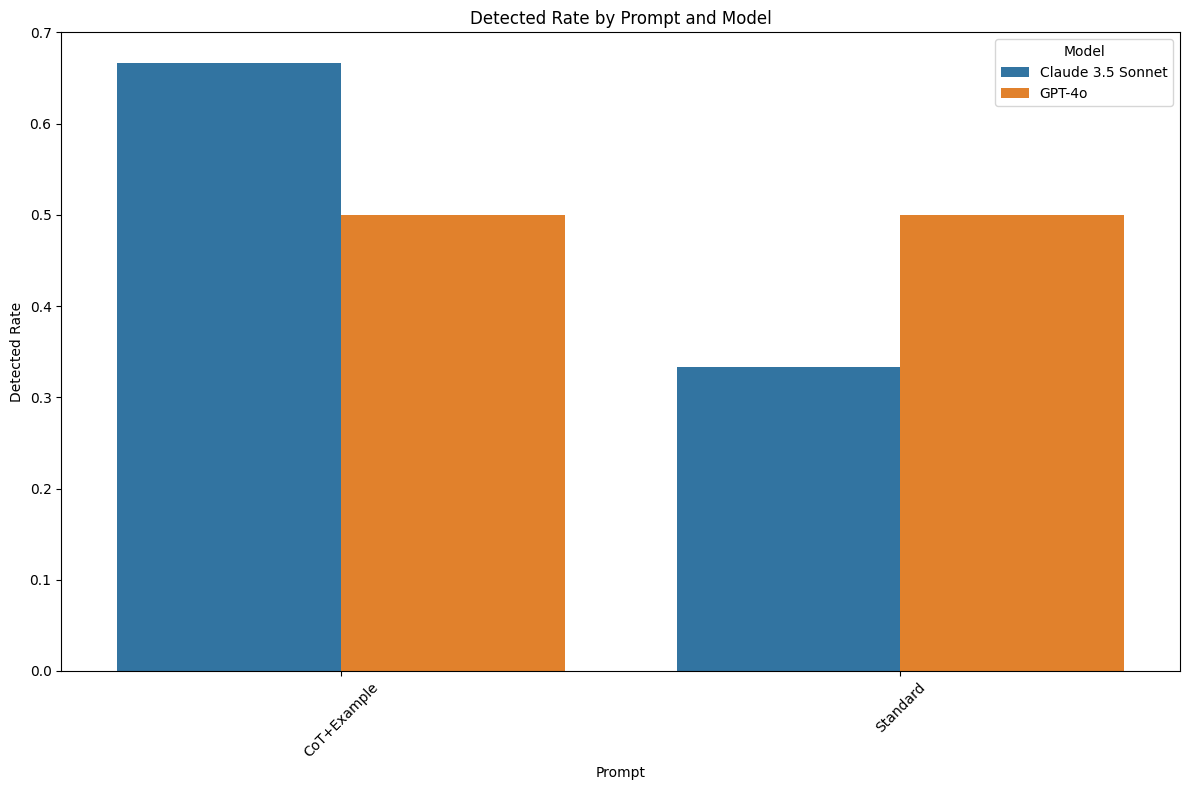

In [39]:
sns_data_prompt_model = df.groupby(['Prompt', 'Model'])['Detected'].mean().reset_index()


plt.figure(figsize=(12, 8))
sns.barplot(x='Prompt', y='Detected', hue='Model', data=sns_data_prompt_model)
plt.title('Detected Rate by Prompt and Model')
plt.xlabel('Prompt')
plt.ylabel('Detected Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
improvement_suggestion_df = df[df['ImprovementQuality'] > 0]
improvement_suggestion_df = improvement_suggestion_df.groupby(['Prompt', 'Model'])['ImprovementQuality']

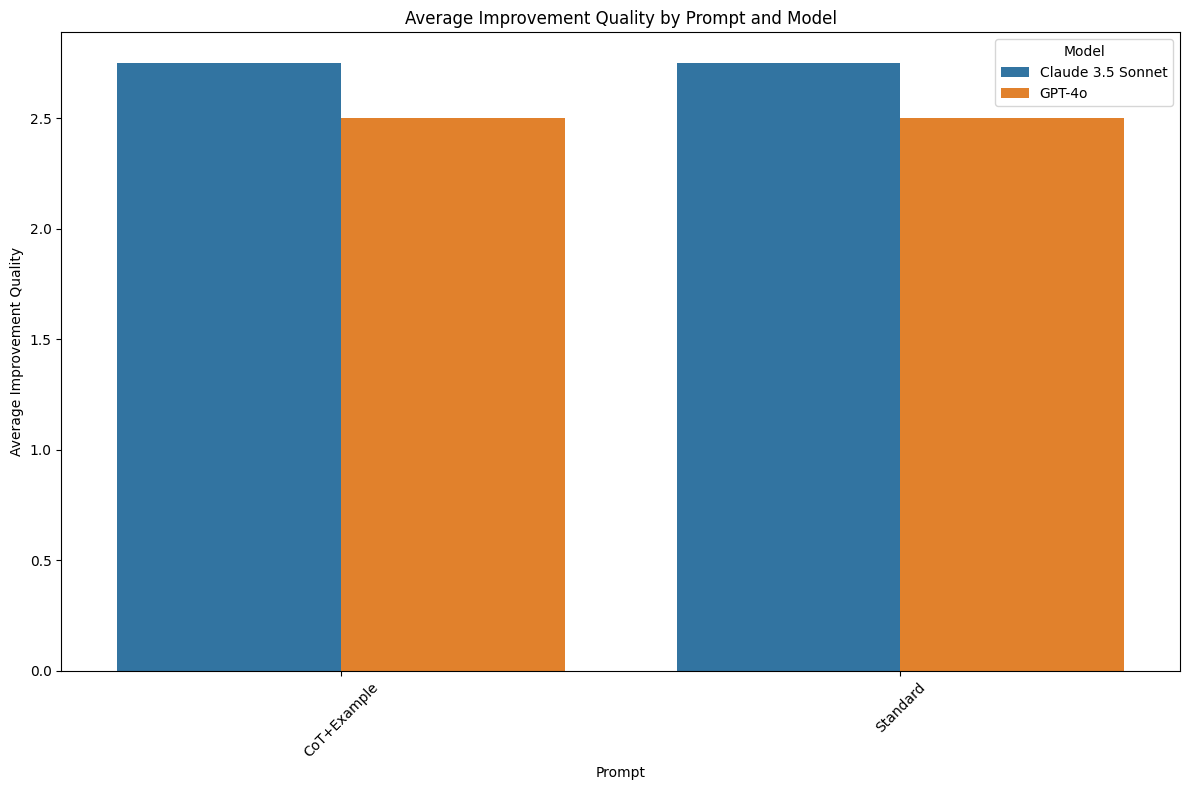

In [41]:
improvement_suggestion_mean = improvement_suggestion_df.mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='Prompt', y='ImprovementQuality', hue='Model', data=improvement_suggestion_mean)
plt.title('Average Improvement Quality by Prompt and Model')
plt.xlabel('Prompt')
plt.ylabel('Average Improvement Quality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_191482/3810676330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improvement_suggestion_df['QualityLabel'] = improvement_suggestion_df['ImprovementQuality'].apply(quality_label)


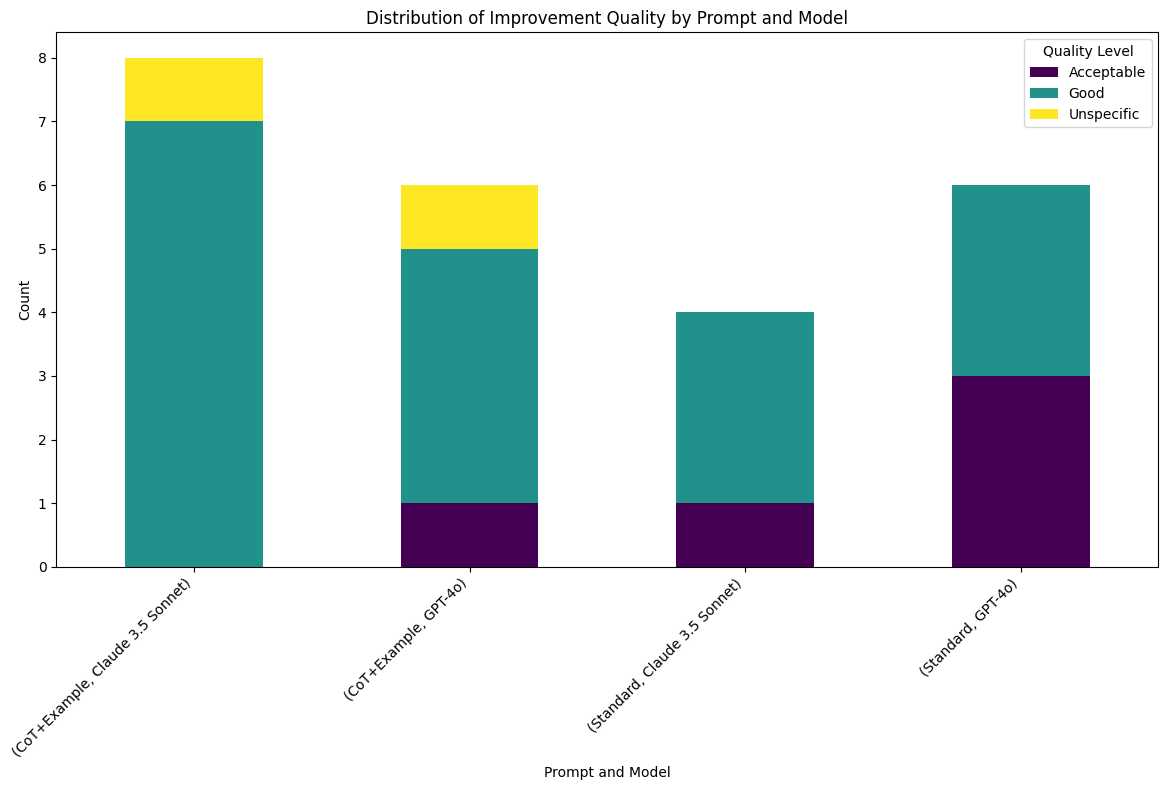

In [43]:
def quality_label(value):
    if value == 1:
        return 'Unspecific'
    elif value == 2:
        return 'Acceptable'
    elif value == 3:
        return 'Good'
    
improvement_suggestion_df = df[df['ImprovementQuality'] > 0]
improvement_suggestion_df['QualityLabel'] = improvement_suggestion_df['ImprovementQuality'].apply(quality_label)

grouped = improvement_suggestion_df.groupby(['Prompt', 'Model', 'QualityLabel']).size().reset_index(name='Count')

pivot = grouped.pivot(index=['Prompt', 'Model'], columns='QualityLabel', values='Count').fillna(0)

pivot.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Distribution of Improvement Quality by Prompt and Model')
plt.ylabel('Count')
plt.xlabel('Prompt and Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Quality Level')
plt.tight_layout()
plt.show()